-------------------------------------------------------------------
# WTW 801 Assignment 2
## Student Name: Muofhe Masikhwa
## Student Number: 22902466
-------------------------------------------------------------

## Assignment Summary
This assignment has two parts. `Part 1` requires simulation of 1{,}500 observations of a trivariate normal $(x,y,z)$ with the given mean vector and covariance, implement PCA from `first principles` and then report the three eigenvectors and eigenvalues, verify orthogonality via pointwise products, and compare $v_1 \cdot v_3$ with $x \cdot z$. 

`Part 2` uses at least five years of daily prices for six U.S.\ companies: compute returns; set the last three months aside as `Data Set 2` (out-of-sample), with the remainder as `Data Set 1`. On `Data Set 1`, we build a three-factor model using the sample covariance and present factor loadings and factor series that will help us interpret factors, and report the variance share of the first component. Furthermore, we need to assess whether any factor's returns in 2025 differ from prior years (e.g., tariffs). Then redo the model with covariance shrinkage toward $\mu I$ with weight $\gamma\in\bigl(0,\tfrac12\bigr)$, and compare out-of-sample performance on `Data Set 2`.

#### NB: For Part 2, we used the yfinance library to dowload data from yahoo finance. This library can be installed using the command: pipinstall yfinance

In [1]:
from pathlib import Path
from typing import Tuple, Union
from typing import List, Dict, Tuple, Union
from datetime import date
import itertools
import numpy as np
import random
random.seed(42)
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import preprocessing

# Question 1 (Principal Component Analysis)

#### Generate the data

In [4]:
def generate_scaled_multivariate_data(mean_vector: np.ndarray,covariance_matrix: np.ndarray,
                                      n_samples: int = 150) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate and scale multivariate normal distributed data.
    
    Args:
        mean_vector: Mean vector for the multivariate normal distribution.
        covariance_matrix: Covariance matrix for the multivariate normal distribution.
        n_samples: Number of samples to generate. Default is 1500.
        
    Returns:
        tuple: Three arrays containing the scaled x, y, and z data.
    """
    # Generate multivariate normal samples
    raw_samples = np.random.multivariate_normal(mean_vector, covariance_matrix, n_samples).T
    
    return raw_samples

In [7]:
# Usage the function to generate the data
mean_vector = np.array([2, 3, 0])
covariance_matrix = np.array([[10, 7, 5],[7, 6, 4],[5, 4, 3]])
raw_samples = generate_scaled_multivariate_data(mean_vector, covariance_matrix)

# Extract individual dimensions
x_data = raw_samples[0, :]
y_data = raw_samples[1, :]
z_data = raw_samples[2, :]

#### Subtract the mean of each column and compute the covariance matrix $C_{X} = \frac{1}{N-1}X^{T}X$

In [10]:
def compute_covariance_matrix(data: np.ndarray) -> np.ndarray:
    """
    Compute the covariance matrix of the given data.
    
    Args:
        data: Input data array with shape (n_samples, n_features)
              where each column represents a sample.
    
    Returns:
        np.ndarray: The covariance matrix with shape (n_features, n_features).
    """
    # Transpose to have samples as rows
    data_transposed = data.T
    
    # Calculate mean along each feature
    feature_means = np.mean(data_transposed, axis=0)
    
    # Center the data by subtracting the mean
    centered_data = data_transposed - feature_means
    
    # Calculate covariance matrix using the formula:
    # cov = (1/(n-1)) * (X - mean(X))^T * (X - mean(X))
    n_samples = data.shape[1]
    covariance_matrix = (1 / (n_samples - 1)) * centered_data.T.dot(centered_data)
    
    return covariance_matrix


In [12]:
# Calculate the covariance matrix for scale_data
covariance = compute_covariance_matrix(raw_samples)
covariance

array([[9.62125833, 6.67483561, 4.59643095],
       [6.67483561, 5.73555859, 3.68822705],
       [4.59643095, 3.68822705, 2.71915994]])

#### Compute the eigenvalues and eigenvectors of the covaraince matrix $C_{X}$

In [15]:
eigenvalues, eigenvectors = np.linalg.eig(covariance)
eigenvalues  # Return eigenvalues for inspection

array([17.05131543,  0.78982358,  0.23483784])

#### Sort the eigentvalues and compute the explained variance

In [18]:
def sort_eigenvalues_and_vectors(eig_vals: np.ndarray, eig_vecs: np.ndarray) -> list:
    """
    Sort eigenvalues in descending order and pair them with their corresponding eigenvectors.
    
    Args:
        eig_vals (np.ndarray): Array of eigenvalues
        eig_vecs (np.ndarray): Matrix of eigenvectors as columns
        
    Returns:
        list: List of tuples containing (eigenvalue, eigenvector) pairs sorted by descending eigenvalue magnitude
    """
    # Create pairs of eigenvalues and eigenvectors
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
    
    # Sort pairs by eigenvalue magnitude in descending order
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    
    return eig_pairs

sorted_eig_pairs = sort_eigenvalues_and_vectors(eigenvalues, eigenvectors)

# Display eigenvalues in descending order with formatted output
print('Eigenvalues in descending order:')
for index, (eigenvalue, eigenvector) in enumerate(sorted_eig_pairs, start=1):
    print(f"Eigenvalue {index}: {eigenvalue:.6f}")

Eigenvalues in descending order:
Eigenvalue 1: 17.051315
Eigenvalue 2: 0.789824
Eigenvalue 3: 0.234838


In [20]:
def calculate_variance_explained(eigenvalues: list[float]) -> tuple[list[float], list[float]]:
    """
    Calculate the percentage of variance explained by each principal component
    and the cumulative variance explained.
    
    Args:
        eigenvalues: List of eigenvalues from PCA
        
    Returns:
        tuple: (variance_explained, cumulative_variance_explained)
            - variance_explained: Percentage of variance explained by each component
            - cumulative_variance_explained: Cumulative percentage of variance explained
    """
    total_variance = sum(eigenvalues)
    # Sort eigenvalues in descending order and calculate percentage variance
    sorted_eigenvalues = sorted(eigenvalues, reverse=True)
    variance_explained = [(value / total_variance) for value in sorted_eigenvalues]
    # Calculate cumulative variance explained
    cumulative_variance_explained = np.cumsum(variance_explained)
    
    return variance_explained, cumulative_variance_explained

# Calculate variance explained metrics
variance_explained, cumulative_variance_explained = calculate_variance_explained(eigenvalues)

# Display results
print('Variance captured by each component is \n', variance_explained)
print(65 * '=')
print('Variance captured along each component is \n', cumulative_variance_explained)

Variance captured by each component is 
 [0.9433136348823695, 0.04369465558451634, 0.01299170953311425]
Variance captured along each component is 
 [0.94331363 0.98700829 1.        ]


In [22]:
# Print information about each principal component
for i in range(len(eigenvectors)):
    print(f'The {i+1}{"st" if i==0 else "nd" if i==1 else "rd" if i==2 else "th"} '
          f'principal component is {eigenvectors[i]} with {variance_explained[i]:.5f} as principal value'
         )
    print('='*100)

# Calculate and print dot products between components
dot_products = [np.dot(x, y) for x, y in itertools.combinations(eigenvectors[:len(eigenvectors)], 2)]

# Print dot products between components
combinations = list(itertools.combinations(range(1, len(eigenvectors)+1), 2))
for idx, (i, j) in enumerate(combinations):
    ordinal_i = f'{i}{"st" if i==1 else "nd" if i==2 else "rd" if i==3 else "th"}'
    ordinal_j = f'{j}{"st" if j==1 else "nd" if j==2 else "rd" if j==3 else "th"}'
        
    print(f'The dot product between the {ordinal_i} and {ordinal_j} component is {dot_products[idx]:.10f}')
    print('-'*67)

The 1st principal component is [ 0.73710077  0.67080628 -0.08186196] with 0.94331 as principal value
The 2nd principal component is [ 0.55870615 -0.67306027 -0.48460016] with 0.04369 as principal value
The 3rd principal component is [ 0.38017086 -0.31146237  0.87089684] with 0.01299 as principal value
The dot product between the 1st and 2nd component is 0.0000000000
-------------------------------------------------------------------
The dot product between the 1st and 3rd component is -0.0000000000
-------------------------------------------------------------------
The dot product between the 2nd and 3rd component is 0.0000000000
-------------------------------------------------------------------


### Plot the principal components

In [25]:
def create_pca_variance_plot(eigenvectors, variance_explained, figsize=(8, 6)):
    """
    Creates a bar plot showing the explained variance for each principal component.
    
    Args:
        eigenvectors (array-like): The eigenvectors from PCA.
        variance_explained (array-like): The explained variance ratio for each component.
        figsize (tuple, optional): Figure size as (width, height). Defaults to (8, 6).
        
    Returns:
        tuple: Figure and axes objects for further customization if needed.
    """
    # Create labels for each principal component
    labels = [f'PC{i}' for i in range(1, len(eigenvectors) + 1)]
    
    # Create the bar plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set background and plot bars
    ax.patch.set_facecolor('lightskyblue')
    ax.bar(range(len(eigenvectors)), height=variance_explained, color='blue')
    
    # Configure x-axis
    ax.set_xticks(range(min(3, len(eigenvectors))))
    ax.set_xticklabels(labels[:3], fontsize=14, weight='bold')
    ax.set_xlabel('Principal Components', fontsize=14, weight='bold')
    
    # Configure y-axis
    ax.set_yticks(ax.get_yticks().tolist())
    ax.set_yticklabels([f"{x:.2%}" for x in ax.get_yticks()], 
                       fontsize=11, weight='bold')
    ax.set_ylabel('Explained Variance', fontsize=14, weight='bold')
    
    # Add grid
    ax.grid(linestyle=':', linewidth=0.8)
    
    # Add title
    #fig.suptitle('Variance Explained by Each Principal Component',
    #             fontsize=16, fontweight='bold',
     #            bbox=dict(facecolor='lightgrey',
     #                      edgecolor='black',
    #                       boxstyle='round,pad=0.6'),
     #            y=1.02)
    fig.tight_layout()
    plt.savefig('PCA.eps')
    return fig, ax

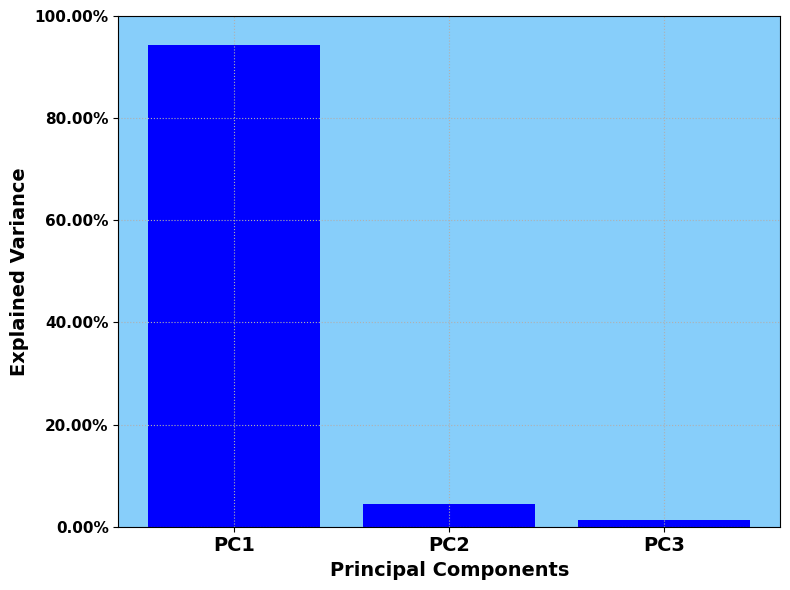

In [27]:
fig, ax = create_pca_variance_plot(eigenvectors, variance_explained)
plt.show()

# Question 2

### Dowload data from Yahoo finance

In [31]:
START_DATE = "2020-01-01"  # Start date ensuring >1000 daily observations
END_DATE = "2025-09-30"    # End date for data collection
K = 3                       # number of factors (keep = 3 for the assignment)
GAMMA = 0.25                # shrinkage weight, must satisfy 0 < GAMMA < 0.5
USE_LOG_RETURNS = True      # True: log returns; False: simple returns

# Dictionary mapping stock tickers to company names
TICKERS = {
    "AAPL": "Apple Inc.",
    "MSFT": "Microsoft Corporation",
    "GOOGL": "Alphabet Inc. (Class A)",
    "AMZN": "Amazon.com, Inc.",
    "META": "Meta Platforms, Inc.",
    "TSLA": "Tesla, Inc.",
    "BRK-B": "Berkshire Hathaway Inc. (Class B)",
    "NVDA": "NVIDIA Corporation",
    "JPM": "JPMorgan Chase & Co.",
    "JNJ": "Johnson & Johnson"
}

# Extract list of ticker symbols for data retrieval
TICKER_LIST = list(TICKERS.keys())

In [33]:
def download_stock_data(tickers: list, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Download daily adjusted stock data for the specified tickers.
    
    Args:
        tickers: List of stock ticker symbols
        start_date: Start date in 'YYYY-MM-DD' format
        end_date: End date in 'YYYY-MM-DD' format
        
    Returns:
        DataFrame containing the downloaded stock data
    """
    return yf.download(tickers,start=start_date,end=end_date,interval="1d",
                       auto_adjust=True,  # Provides dividend & split adjusted OHLC
                       group_by="ticker",threads=True,progress=False
                      )

def extract_adjusted_closing_prices(stock_data: pd.DataFrame) -> pd.DataFrame:
    """
    Extract and clean adjusted closing prices from stock data.
    
    Args:
        stock_data: MultiIndex DataFrame with (ticker, field) structure
        
    Returns:
        DataFrame with adjusted closing prices for all tickers
    """
    # Extract 'Close' slice from MultiIndex
    close_prices = stock_data.xs("Close", axis=1, level=1).sort_index()
    
    # Remove any duplicate indices (keeping first occurrence)
    close_prices = close_prices.loc[~close_prices.index.duplicated(keep="first")]
    
    # Remove rows where all tickers have NaN values
    close_prices = close_prices.dropna(how="all")

    # Compute returns
    returns = close_prices.pct_change().dropna()       # simple returns r_t = (I_t - I_{t-1}) / I_{t-1}
    logrets = np.log(close_prices).diff().dropna()     # log returns
    
    return logrets

In [35]:
USA_Data = download_stock_data(TICKER_LIST, START_DATE, END_DATE)

# Extract adjusted closing prices returns
USA_Data_Close = extract_adjusted_closing_prices(USA_Data)
USA_Data_Close = USA_Data_Close.reset_index()
USA_Data_Close.head()

Ticker,Date,BRK-B,AMZN,MSFT,META,JNJ,JPM,TSLA,NVDA,GOOGL,AAPL
0,2020-01-03,-0.009724,-0.012213,-0.012530,-0.005305,-0.011645,-0.013284,0.029203,-0.016135,-0.005245,-0.009769
1,2020-01-06,0.003575,0.014776,0.002582,0.018658,-0.001248,-0.000796,0.019072,0.004185,0.026305,0.007936
2,2020-01-07,-0.004725,0.002089,-0.009160,0.002161,0.006088,-0.017147,0.038067,0.012034,-0.001933,-0.004714
3,2020-01-08,0.000310,-0.007839,0.015803,0.010087,-0.000138,0.007771,0.048033,0.001874,0.007092,0.015958
4,2020-01-09,0.011702,0.004788,0.012416,0.014209,0.002962,0.003645,-0.022189,0.010923,0.010443,0.021018


In [36]:
## Export the dataframe to excel file 
USA_Data_Close.to_excel('USAStocksReturns.xlsx',index=False)

## Load the exported file

In [38]:
USA_Data = pd.read_excel('USAStocksReturns.xlsx')
USA_Data = USA_Data.set_index('Date')
USA_Data.head()

,BRK-B,AMZN,MSFT,META,JNJ,JPM,TSLA,NVDA,GOOGL,AAPL
Date,,,,,,,,,,
2020-01-03,-0.009724,-0.012213,-0.012530,-0.005305,-0.011645,-0.013284,0.029203,-0.016135,-0.005245,-0.009769
2020-01-06,0.003575,0.014776,0.002582,0.018658,-0.001248,-0.000796,0.019072,0.004185,0.026305,0.007936
2020-01-07,-0.004725,0.002089,-0.009160,0.002161,0.006088,-0.017147,0.038067,0.012034,-0.001933,-0.004714
2020-01-08,0.000310,-0.007839,0.015803,0.010087,-0.000138,0.007771,0.048033,0.001874,0.007092,0.015958
2020-01-09,0.011702,0.004788,0.012416,0.014209,0.002962,0.003645,-0.022189,0.010923,0.010443,0.021018


In [39]:
stock_names_selected = ['GOOGL', 'MSFT', 'JPM', 'TSLA', 'AMZN', 'NVDA']
USA_Data = USA_Data[stock_names_selected]
USA_Data.head()

,GOOGL,MSFT,JPM,TSLA,AMZN,NVDA
Date,,,,,,
2020-01-03,-0.005245,-0.012530,-0.013284,0.029203,-0.012213,-0.016135
2020-01-06,0.026305,0.002582,-0.000796,0.019072,0.014776,0.004185
2020-01-07,-0.001933,-0.009160,-0.017147,0.038067,0.002089,0.012034
2020-01-08,0.007092,0.015803,0.007771,0.048033,-0.007839,0.001874
2020-01-09,0.010443,0.012416,0.003645,-0.022189,0.004788,0.010923


### Split the data into train and test

In [41]:
def split_data(data: pd.DataFrame, months_for_test: int = 3) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split a time series DataFrame into training and testing sets based on date.
    
    Args:
        data (pd.DataFrame): DataFrame containing a 'Date' column
        months_for_test (int, optional): Number of months to include in test set. Defaults to 3.
    
    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: Training and testing DataFrames
    """
    last_date = data.index.max()
    cutoff_date = (last_date - pd.DateOffset(months=months_for_test)).normalize()
    
    test_data = data.loc[data.index > cutoff_date]  # Recent data for testing (3 months)
    train_data = data.loc[data.index <= cutoff_date]  # Earlier data for training
    
    return train_data, test_data

# Split the data into training and testing sets
TrainData, TestData = split_data(USA_Data)

In [43]:
TrainData.head()

,GOOGL,MSFT,JPM,TSLA,AMZN,NVDA
Date,,,,,,
2020-01-03,-0.005245,-0.012530,-0.013284,0.029203,-0.012213,-0.016135
2020-01-06,0.026305,0.002582,-0.000796,0.019072,0.014776,0.004185
2020-01-07,-0.001933,-0.009160,-0.017147,0.038067,0.002089,0.012034
2020-01-08,0.007092,0.015803,0.007771,0.048033,-0.007839,0.001874
2020-01-09,0.010443,0.012416,0.003645,-0.022189,0.004788,0.010923


#### Compute the covariance matrix from the Train Data

In [46]:
def calculate_covariance_matrix(data: np.ndarray) -> np.ndarray:
    """
    Calculate the covariance matrix for the given data.
    
    Args:
        data (np.ndarray): The input data array, assumed to be scaled.
        
    Returns:
        np.ndarray: The calculated covariance matrix.
    """
    # Calculate the mean along each feature (column)
    mean_vector = np.mean(data, axis=0)
    
    # Calculate the covariance matrix using the formula:
    # cov = (1/(n-1)) * (X - mean)^T * (X - mean)
    n_samples = data.shape[0]
    centered_data = data - mean_vector
    covariance_matrix = (1/(n_samples-1)) * centered_data.T.dot(centered_data)
    
    return covariance_matrix

# Calculate the covariance matrix for USA_scaled data
covariance_USA = calculate_covariance_matrix(USA_Data)
print('The covariance matrix is')
covariance_USA

The covariance matrix is


,GOOGL,MSFT,JPM,TSLA,AMZN,NVDA
GOOGL,0.000422,0.000278,0.000168,0.000368,0.000298,0.000407
MSFT,0.000278,0.000356,0.000164,0.000365,0.000288,0.000434
JPM,0.000168,0.000164,0.000398,0.000261,0.000137,0.000235
TSLA,0.000368,0.000365,0.000261,0.001788,0.000428,0.000689
AMZN,0.000298,0.000288,0.000137,0.000428,0.000510,0.000447
NVDA,0.000407,0.000434,0.000235,0.000689,0.000447,0.001137


In [47]:
def pca_from_cov(S: Union[np.ndarray, pd.DataFrame], k: int = 3) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
    """
    Perform PCA "Manually" on a covariance matrix via eigen-decomposition.
    
    Args:
        S (np.ndarray or pd.DataFrame): Covariance matrix (n x n), symmetric.
        k (int): Number of leading components to keep. Default is 3.
    
    Returns:
        Tuple containing:
            np.ndarray: Top-k eigenvalues in descending order.
            np.ndarray: Corresponding eigenvectors (n x k; columns are PCs).
            np.ndarray: Explained variance ratios for the top-k PCs.
            float: Total variance (trace of S).
    
    Notes:
        Uses numpy.linalg.eigh for symmetric matrices, then sorts in descending order.
    """
    # Convert input to numpy array if it's not already
    S = np.asarray(S)
    
    # Ensure matrix is symmetric by averaging with its transpose
    S_symmetric = (S + S.T) / 2.0
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(S_symmetric)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[idx]
    sorted_eigenvectors = eigenvectors[:, idx]
    
    # Calculate total variance and explained variance ratio
    total_variance = float(np.trace(S_symmetric))
    
    # Avoid division by zero
    if total_variance > 0:
        explained_variance_ratio = sorted_eigenvalues / total_variance
    else:
        explained_variance_ratio = np.zeros_like(sorted_eigenvalues)
    
    return (sorted_eigenvalues[:k], sorted_eigenvectors[:, :k], explained_variance_ratio[:k],total_variance)

In [52]:
# Apply PCA using the function
k = 3  # Number of principal components to keep
eigenvalues, eigenvectors, explained_variance_ratio, total_variance = pca_from_cov(covariance_USA, k)

# 3. Analyze the results
print(65*'=')
print(f"Top {k} eigenvalues: {eigenvalues}")
print(65*'=')
print(f"Explained variance ratios: {explained_variance_ratio}")
print(65*'=')
print(f"Total variance: {total_variance}")
print(65*'=')
print(f"Cumulative explained variance: {np.sum(explained_variance_ratio):.4f}")
print(65*'=')

Top 3 eigenvalues: [0.00284482 0.00085046 0.00036064]
Explained variance ratios: [0.61705229 0.184467   0.07822443]
Total variance: 0.00461034153646114
Cumulative explained variance: 0.8797


## (a) Building a Three Fatcor Model

In [57]:
def factor_scores(X_df, V):
    '''
    Purpose:
       Project asset returns onto the PC loadings to get factor return series.
    Inputs:
       X_df (DataFrame): returns (T x n).
       V (ndarray): eigenvectors (n x k), columns are principal directions.
    Returns:
       DataFrame or ndarray (T x k): factor returns F = X V.
    Notes:
       You typically wrap the result into a DataFrame with factor column names.    
    '''
    F = X_df @ V
    F.columns = [f"F{j+1}" for j in range(V.shape[1])]
    
    return  pd.DataFrame(F)

In [59]:
Factor_Loadings = factor_scores(TrainData, eigenvectors)
Factor_Loadings.head()

,F1,F2,F3
Date,,,
2020-01-03,-0.000987,-0.038614,0.007613
2020-01-06,-0.027355,-0.000725,-0.010228
2020-01-07,-0.026940,-0.025533,0.021648
2020-01-08,-0.039058,-0.029220,-0.004895
2020-01-09,0.001406,0.029142,-0.004289


We estimate a $3$-factor model on Data Set 1 using the following formula:
\begin{equation}
	R_{i}  = \alpha_i + \sum_{j=1}^{3} \beta_{i}^{j} {F_j} \;+\; \varepsilon_{i},
\end{equation}
where $R_{i}\in\mathbb{R}^n$ are asset returns os asset $i$, $F_{j}$ are the factor (component) vectors.

In [62]:
def fit_factor_ts_regs(R_train: pd.DataFrame,F_train: pd.DataFrame, robust: str = "HC3"):
    """
    Fit r_i,t = alpha_i + beta_i' F_t + eps_i,t for each asset i by OLS.
    Returns:
      coefs_df: rows=assets, cols=['alpha','F1',...,'FK']
      stats_df: rows=assets, cols=['R2','AdjR2','sigma','DW','AIC','BIC']
      se_df:    robust std errors for the coefficients (same shape as coefs_df)
    """
    # Align on dates
    R = R_train.copy()
    F = F_train.copy()
    idx = R.index.intersection(F.index)
    R, F = R.loc[idx], F.loc[idx]
    # Regressors with intercept
    X = sm.add_constant(F)           # columns: ['const','F1','F2','F3',...]
    coef_rows, se_rows, stat_rows = [], [], []
    asset_names = []
    for asset in R.columns:
        y = R[asset].values
        model = sm.OLS(y, X.values)
        res = model.fit(cov_type=robust)  
        # Collect
        cols = ['alpha'] + list(F.columns)  # rename const -> alpha
        coef = np.r_[res.params[0], res.params[1:]]
        se   = np.r_[res.bse[0],    res.bse[1:]]
        coef_rows.append(coef)
        se_rows.append(se)
        # Quick stats
        dw = sm.stats.stattools.durbin_watson(res.resid)
        stat_rows.append([res.rsquared, res.rsquared_adj, res.scale**0.5, dw, res.aic, res.bic])
        asset_names.append(asset)

    coefs_df = pd.DataFrame(coef_rows, index=asset_names, columns=['alpha'] + list(F.columns))
    se_df    = pd.DataFrame(se_rows,    index=asset_names, columns=['alpha'] + list(F.columns))
    stats_df = pd.DataFrame(stat_rows,  index=asset_names,
                            columns=['R2','AdjR2','sigma','DW','AIC','BIC'])
    return coefs_df, se_df, stats_df

In [64]:
coefs_df, se_df, stats_df = fit_factor_ts_regs(TrainData,Factor_Loadings)
coefs_df

,alpha,F1,F2,F3
GOOGL,-0.000102,-0.269655,0.256426,-0.357336
MSFT,-0.000021,-0.267975,0.248054,-0.204516
JPM,0.000348,-0.175846,0.113859,-0.622509
TSLA,-0.000001,-0.686255,-0.725348,0.047967
AMZN,-0.000322,-0.301684,0.247856,-0.273126
NVDA,0.000137,-0.512441,0.521732,0.605143


In [66]:
def reconstruct_returns(F_df, V,stock_names):
    ''' 
    Purpose:
        Reconstruct returns from factors & loadings (low-rank approx).
    Inputs:
        F_df (DataFrame/ndarray): factor returns (T x k).
        V (ndarray): loadings (n x k).
    Returns:
        DataFrame or ndarray (T x n): reconstructed returns X_hat = F V^T.
    Notes:
        Useful for in-sample fit checks and OOS projection quality.
    '''

    Xhat = F_df @ V.T
    Xhat.columns = TrainData.columns
    return  pd.DataFrame(Xhat)
TrainReturns = reconstruct_returns(Factor_Loadings,eigenvectors,stock_names_selected)
TrainReturns.head()

,GOOGL,MSFT,JPM,TSLA,AMZN,NVDA
Date,,,,,,
2020-01-03,-0.012285,-0.010866,-0.008904,0.029053,-0.011510,-0.015004
2020-01-06,0.010914,0.009179,0.011022,0.018808,0.010937,0.007430
2020-01-07,-0.007027,-0.003512,-0.011494,0.038048,-0.004326,0.013645
2020-01-08,0.004919,0.004147,0.006556,0.047767,0.005836,0.001809
2020-01-09,0.008566,0.007731,0.005707,-0.022310,0.008080,0.011869


## Evaluate the Perfomance of the 3-Factor Model

In [69]:
def oos_metrics(X_true, X_hat):
    R = (X_true - X_hat).to_numpy()
    sse = float(np.sum(R * R))
    S = X_true.to_numpy()
    sst = float(np.sum(S * S))
    r2 = (1.0 - sse/sst) if sst > 0 else np.nan
    rmse = float(np.sqrt(np.mean(R * R)))
    # per-asset R^2
    r2_cols = {}
    for col in X_true.columns:
        e = (X_true[col] - X_hat[col]).to_numpy()
        sse_c = float(np.sum(e * e))
        sst_c = float(np.sum(X_true[col].to_numpy() ** 2))
        r2_cols[col] = (1.0 - sse_c/sst_c) if sst_c > 0 else np.nan
    return r2, rmse, pd.Series(r2_cols, name="R2_per_asset")

In [71]:
r2_overall_train, rmse_train, r2_per_asset_train = oos_metrics(TrainData, TrainReturns)
r2_overall_train

0.882235582505915

In [73]:
r2_per_asset_train

GOOGL    0.744058
MSFT     0.765234
JPM      0.594846
TSLA     0.999954
AMZN     0.673930
NVDA     0.977666
Name: R2_per_asset, dtype: float64

## (b) Commonality between the assets

In [76]:
def top_loadings_table(V, cols, topn=3):
    tbl = {}
    for j in range(V.shape[1]):
        v = pd.Series(V[:, j], index=cols).sort_values(ascending=False)
        tbl[f"F{j+1}_top_pos"] = list(v.head(topn).index)
        tbl[f"F{j+1}_top_neg"] = list(v.tail(topn).index)
    return pd.DataFrame.from_dict(tbl, orient="index")

In [78]:
tops = top_loadings_table(eigenvectors, TrainData.columns, topn=3)
tops

,0,1,2
F1_top_pos,JPM,MSFT,GOOGL
F1_top_neg,AMZN,NVDA,TSLA
F2_top_pos,NVDA,GOOGL,AMZN
F2_top_neg,MSFT,JPM,TSLA
F3_top_pos,NVDA,TSLA,MSFT
F3_top_neg,AMZN,GOOGL,JPM


In [80]:
def render_interpretation(loadings: pd.DataFrame, top_table: pd.DataFrame, evr: list | None = None) -> str:
    """
    Build a concise, report-ready paragraph per factor using top +/- lists and a simple label heuristic.
    """
    lines = []
    m = min(3, loadings.shape[1])
    for j in range(1, m+1):
        pc = f"F{j}"
        # Top lists
        pos = ", ".join(top_table.loc[f"F{j}_top_pos"])
        neg = ", ".join(top_table.loc[f"F{j}_top_neg"])
        # Heuristic label
        label = "Market-like" if is_market_like_factor(loadings[pc]) else "Contrast/theme"
        evr_text = f" (explains ~{100*evr[j-1]:.1f}% of variance)" if (evr is not None and len(evr) >= j) else ""
        # Paragraph
        lines.append(
            f"Factor {j} ({pc}){evr_text}: "
            f"highest positive loadings on [{pos}] and highest negative loadings on [{neg}]. "
            f"This pattern suggests a **{label}** factor: assets on the positive side tend to move together, "
            f"while those on the negative side move in the opposite direction. "
        )
    return "\n\n".join(lines)

def is_market_like_factor(weights: pd.Series, threshold: float = 0.8) -> bool:
    """
    Heuristic: if ≥ threshold of loadings share the same sign, call it 'market-like'.
    Returns True/False.
    """
    pos_ratio = (weights > 0).mean()
    neg_ratio = (weights < 0).mean()
    return (pos_ratio >= threshold) or (neg_ratio >= threshold)

In [82]:
# Create interpretation text
text = render_interpretation(Factor_Loadings, tops, evr=explained_variance_ratio)
text

'Factor 1 (F1) (explains ~61.7% of variance): highest positive loadings on [JPM, MSFT, GOOGL] and highest negative loadings on [AMZN, NVDA, TSLA]. This pattern suggests a **Contrast/theme** factor: assets on the positive side tend to move together, while those on the negative side move in the opposite direction. \n\nFactor 2 (F2) (explains ~18.4% of variance): highest positive loadings on [NVDA, GOOGL, AMZN] and highest negative loadings on [MSFT, JPM, TSLA]. This pattern suggests a **Contrast/theme** factor: assets on the positive side tend to move together, while those on the negative side move in the opposite direction. \n\nFactor 3 (F3) (explains ~7.8% of variance): highest positive loadings on [NVDA, TSLA, MSFT] and highest negative loadings on [AMZN, GOOGL, JPM]. This pattern suggests a **Contrast/theme** factor: assets on the positive side tend to move together, while those on the negative side move in the opposite direction. '

## (c) Variance is explained by the first principal component

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


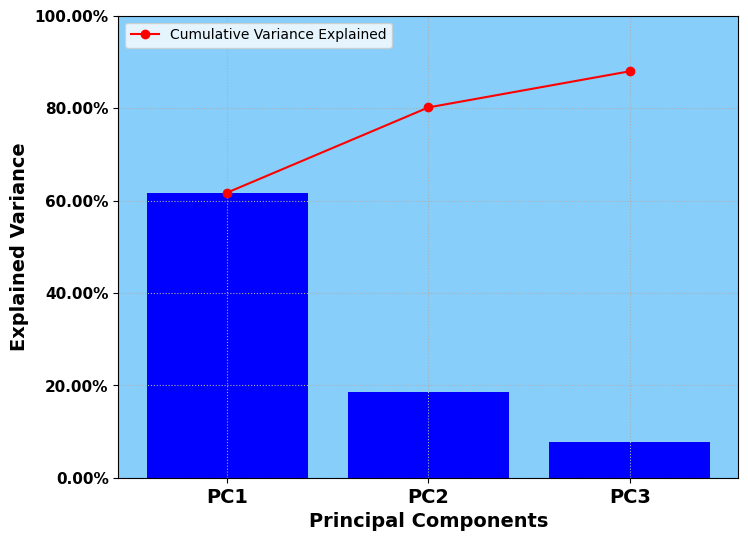

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='Principal Components', ylabel='Explained Variance'>)

In [85]:
def create_scree_plot(explained_variance_ratio: list, figsize: tuple = (8, 6), save_path: str = 'PCAStocks.eps') -> tuple:
    """
    Creates a scree plot to visualize explained variance from PCA components.
    
    Args:
        explained_variance_ratio (list): List of explained variance ratios for each principal component
        figsize (tuple, optional): Figure size as (width, height). Defaults to (8, 6).
        save_path (str, optional): Path to save the figure. Defaults to 'PCAStocks.eps'.
    
    Returns:
        tuple: Figure and axes objects (fig, ax)
    """
    # Create labels and x-range for plotting
    n_components = len(explained_variance_ratio)
    x_range = range(0, n_components)
    labels = [f'PC{i+1}' for i in range(n_components)]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Style the plot
    ax.patch.set_facecolor('lightskyblue')
    
    # Plot the individual variance bars
    ax.bar(x_range, height=explained_variance_ratio, color='blue')
    
    # Plot the cumulative variance line
    plt.plot(x_range, np.cumsum(explained_variance_ratio), 'ro-', 
             label='Cumulative Variance Explained')
    
    # Configure x-axis
    ax.set_xticks(x_range)
    ax.set_xticklabels(labels, fontsize=14, weight='bold')
    ax.set_xlabel('Principal Components', fontsize=14, weight='bold')
    
    # Configure y-axis
    ticks_loc = ax.get_yticks().tolist()
    ax.set_yticks(ticks_loc)
    ax.set_yticklabels([f"{x:.2%}" for x in ticks_loc], fontsize=11, weight='bold')
    ax.set_ylabel('Explained Variance', fontsize=14, weight='bold')
    
    # Add grid and legend
    plt.grid(linestyle=':', linewidth=0.8)
    plt.legend(loc='upper left')
    
    # Save and show the plot
    plt.savefig(save_path)
    plt.show()
    
    return fig, ax

create_scree_plot(explained_variance_ratio)

## (d) Comparison of terurns in 2025 against previous years

In [88]:
def summarize_by_year(F):
    yr = F.copy()
    yr["year"] = yr.index.year
    means = yr.groupby("year").mean().drop(columns=[], errors="ignore")
    vols  = yr.groupby("year").std(ddof=1).drop(columns=[], errors="ignore")
    cums  = yr.groupby("year").sum()          # simple cumulative sum proxy
    return means, vols, cums

In [90]:
means_by_year, vols_by_year, cums_by_year = summarize_by_year(Factor_Loadings)

In [92]:
means_by_year

,F1,F2,F3
year,,,
2020,-0.008535,-0.003358,0.001225
2021,-0.003938,0.001576,0.000354
2022,0.006102,0.000013,0.000183
2023,-0.006319,0.002148,0.000745
2024,-0.004507,0.001627,0.000655
2025,0.000009,0.002463,-0.000404


In [94]:
vols_by_year

,F1,F2,F3
year,,,
2020,0.069562,0.037072,0.024208
2021,0.039745,0.024351,0.016011
2022,0.063916,0.028649,0.017317
2023,0.041874,0.025055,0.016982
2024,0.042550,0.030779,0.020455
2025,0.063975,0.027990,0.019054


In [96]:
cums_by_year

,F1,F2,F3
year,,,
2020,-2.150927,-0.846259,0.308578
2021,-0.992481,0.397094,0.089203
2022,1.531532,0.003345,0.045962
2023,-1.579809,0.537039,0.186374
2024,-1.135664,0.410004,0.165174
2025,0.001077,0.298003,-0.048833


In [98]:
def compare_2025(means_by_year, vols_by_year, year_focus=2025):
    rows = []
    for f in means_by_year.columns:
        # series of yearly means for factor f
        series = means_by_year[f].dropna()
        if year_focus not in series.index or len(series.index) < 2:
            continue
        base = series.loc[series.index < year_focus]
        mu_2025 = series.loc[year_focus]
        mu_base = float(base.mean())
        sd_base = float(base.std(ddof=1)) if len(base) > 1 else np.nan
        z = (mu_2025 - mu_base) / sd_base if (sd_base is not np.nan and sd_base > 0) else np.nan
        pct = 100.0 * (base <= mu_2025).mean()  # percentile of 2025 within past distribution
        vol_2025 = vols_by_year[f].get(year_focus, np.nan)
        vol_base = float(vols_by_year[f].loc[vols_by_year.index < year_focus].mean())
        vol_ratio = vol_2025 / vol_base if (vol_base is not np.nan and vol_base > 0) else np.nan
        rows.append([f, mu_2025, mu_base, mu_2025 - mu_base, z, pct, vol_2025, vol_base, vol_ratio])
    return pd.DataFrame(rows, columns=[
        "Factor","Mean_2025","Mean_Pre2025","Diff","Zscore","Percentile_vs_Pre",
        "Vol_2025","Vol_Pre_Avg","Vol_Ratio_2025_to_Pre"
    ])

In [100]:
cmp_2025 = compare_2025(means_by_year, vols_by_year, year_focus=2025)
cmp_2025

,Factor,Mean_2025,Mean_Pre2025,Diff,Zscore,Percentile_vs_Pre,Vol_2025,Vol_Pre_Avg,Vol_Ratio_2025_to_Pre
0,F1,0.000009,-0.003440,0.003448,0.612771,80.0,0.063975,0.051530,1.241515
1,F2,0.002463,0.000401,0.002062,0.917014,100.0,0.027990,0.029181,0.959173
2,F3,-0.000404,0.000633,-0.001036,-2.583575,0.0,0.019054,0.018995,1.003124


In [184]:
print(cmp_2025.to_latex())

\begin{tabular}{llrrrrrrrr}
\toprule
 & Factor & Mean_2025 & Mean_Pre2025 & Diff & Zscore & Percentile_vs_Pre & Vol_2025 & Vol_Pre_Avg & Vol_Ratio_2025_to_Pre \\
\midrule
0 & F1 & 0.000009 & -0.003440 & 0.003448 & 0.612771 & 80.000000 & 0.063975 & 0.051530 & 1.241515 \\
1 & F2 & 0.002463 & 0.000401 & 0.002062 & 0.917014 & 100.000000 & 0.027990 & 0.029181 & 0.959173 \\
2 & F3 & -0.000404 & 0.000633 & -0.001036 & -2.583575 & 0.000000 & 0.019054 & 0.018995 & 1.003124 \\
\bottomrule
\end{tabular}



In [102]:
# Short, report-ready text
YEAR_FOCUS = 2025
lines = [f"Part (d): Comparing {YEAR_FOCUS} to earlier years"]
for _, row in cmp_2025.iterrows():
    f = row["Factor"]
    mu_25, mu_base, diff, z, pct = row["Mean_2025"], row["Mean_Pre2025"], row["Diff"], row["Zscore"], row["Percentile_vs_Pre"]
    vr = row["Vol_Ratio_2025_to_Pre"]
    tag = "higher" if diff > 0 else "lower"
    lines.append(
        f"- {f}: The {YEAR_FOCUS} average ({mu_25:.4f}) is {tag} than the pre-{YEAR_FOCUS} average ({mu_base:.4f}) "
        f"by {diff:.4f} (z={z:.2f}, {pct:.0f}th percentile). "
        f"Volatility is {vr:.2f}× the pre-{YEAR_FOCUS} average."
    )
print("\n".join(lines))

Part (d): Comparing 2025 to earlier years
- F1: The 2025 average (0.0000) is higher than the pre-2025 average (-0.0034) by 0.0034 (z=0.61, 80th percentile). Volatility is 1.24× the pre-2025 average.
- F2: The 2025 average (0.0025) is higher than the pre-2025 average (0.0004) by 0.0021 (z=0.92, 100th percentile). Volatility is 0.96× the pre-2025 average.
- F3: The 2025 average (-0.0004) is lower than the pre-2025 average (0.0006) by -0.0010 (z=-2.58, 0th percentile). Volatility is 1.00× the pre-2025 average.


## (e) Shrinking method

In [105]:
def shrink_cov(S: np.ndarray, gamma: float):
    """S_sh = (1-γ) S + γ μ I, with μ = tr(S)/n."""
    n = S.shape[0]
    mu = float(np.trace(S)) / n
    return (1.0 - gamma) * S + gamma * mu * np.eye(n), mu


In [107]:
# ===== Model 2: PCA on shrinkage covariance =====
GAMMA = 0.25        # 0 < GAMMA < 0.5
covariance_USA_shrinked, mu = shrink_cov(covariance_USA, GAMMA)
eigenvalues_shrinked, eigenvectors_shrinked, explained_variance_ratio_shrinked, total_variance_shrinked = pca_from_cov(covariance_USA_shrinked, k=3)

In [109]:
# 3. Analyze the results
print(65*'=')
print(f"Top {k} eigenvalues: {eigenvalues_shrinked}")
print(65*'=')
print(f"Explained variance ratios: {explained_variance_ratio_shrinked}")
print(65*'=')
print(f"Total variance: {total_variance_shrinked}")
print(65*'=')
print(f"Cumulative explained variance: {np.sum(explained_variance_ratio_shrinked):.4f}")
print(65*'=')

Top 3 eigenvalues: [0.00232571 0.00082994 0.00046258]
Explained variance ratios: [0.50445589 0.18001692 0.10033499]
Total variance: 0.00461034153646114
Cumulative explained variance: 0.7848


In [111]:
Factor_Loadings_shrinked = factor_scores(TrainData, eigenvectors_shrinked)
Factor_Loadings_shrinked .head()

,F1,F2,F3
Date,,,
2020-01-03,-0.000987,-0.038614,0.007613
2020-01-06,-0.027355,-0.000725,-0.010228
2020-01-07,-0.026940,-0.025533,0.021648
2020-01-08,-0.039058,-0.029220,-0.004895
2020-01-09,0.001406,0.029142,-0.004289


In [113]:
coefs_df_shrinked, se_df_shrinked, stats_df_shrinked = fit_factor_ts_regs(TrainData,Factor_Loadings_shrinked)
coefs_df_shrinked

,alpha,F1,F2,F3
GOOGL,-0.000102,-0.269655,0.256426,-0.357336
MSFT,-0.000021,-0.267975,0.248054,-0.204516
JPM,0.000348,-0.175846,0.113859,-0.622509
TSLA,-0.000001,-0.686255,-0.725348,0.047967
AMZN,-0.000322,-0.301684,0.247856,-0.273126
NVDA,0.000137,-0.512441,0.521732,0.605143


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


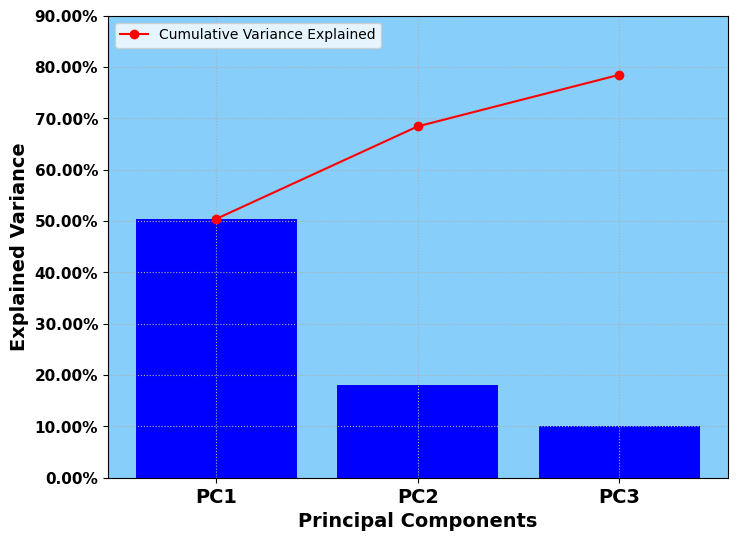

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='Principal Components', ylabel='Explained Variance'>)

In [115]:
create_scree_plot(explained_variance_ratio_shrinked)

## Compute the model evaluation metrics

### Perfomance of Model 1 on Test Data

In [119]:
Factor_Loadings_Model_1 = pd.DataFrame(factor_scores(TestData, eigenvectors), index=TestData.index, columns=[f"F{j+1}" for j in range(k)])
TestReturns_Model1 = reconstruct_returns(Factor_Loadings_Model_1,eigenvectors,stock_names_selected)
TestReturns_Model1.head()

,GOOGL,MSFT,JPM,TSLA,AMZN,NVDA
Date,,,,,,
2025-06-30,-0.003943,-0.003425,-0.004173,-0.018547,-0.004292,-0.003128
2025-07-01,-0.001805,-0.005002,0.005438,-0.054704,-0.005267,-0.028872
2025-07-02,0.005395,0.006885,0.000729,0.048310,0.007834,0.022129
2025-07-03,0.014669,0.012461,0.013411,-0.000754,0.014185,0.012121
2025-07-07,-0.007871,-0.006786,-0.009827,-0.070145,-0.009293,-0.004443


In [121]:
r2_overall_model1, rmse_model1, r2_per_asset_model1 = oos_metrics(TestData, TestReturns_Model1)

In [145]:
rmse_model1

0.008870899471610438

In [171]:
pd.DataFrame([r2_overall_model1, rmse_model1], index = ['Overal R2', 'RMSE'], columns=['value']
            )

,value
Overal R2,0.765940
RMSE,0.008871


In [173]:
pd.DataFrame(r2_per_asset_model1.values,index=r2_per_asset_model1.index, columns=['R-Squared'])

,R-Squared
GOOGL,0.460869
MSFT,0.314735
JPM,0.365933
TSLA,0.999893
AMZN,0.492049
NVDA,0.966307


### Perfomance of Model 2 on Test Data

In [176]:
Factor_Loadings_Model_2 = pd.DataFrame(factor_scores(TestData, eigenvectors_shrinked), index=TestData.index, columns=[f"F{j+1}" for j in range(k)])
TestReturns_Model2 = reconstruct_returns(Factor_Loadings_Model_2,eigenvectors_shrinked,stock_names_selected)
TestReturns_Model2.head()

,GOOGL,MSFT,JPM,TSLA,AMZN,NVDA
Date,,,,,,
2025-06-30,-0.003943,-0.003425,-0.004173,-0.018547,-0.004292,-0.003128
2025-07-01,-0.001805,-0.005002,0.005438,-0.054704,-0.005267,-0.028872
2025-07-02,0.005395,0.006885,0.000729,0.048310,0.007834,0.022129
2025-07-03,0.014669,0.012461,0.013411,-0.000754,0.014185,0.012121
2025-07-07,-0.007871,-0.006786,-0.009827,-0.070145,-0.009293,-0.004443


In [178]:
r2_overall_model2, rmse_model2, r2_per_asset_model2 = oos_metrics(TestData, TestReturns_Model2)

In [180]:
pd.DataFrame([r2_overall_model2, rmse_model2], index = ['Overal R2', 'RMSE'], columns=['value']
            )

,value
Overal R2,0.765940
RMSE,0.008871


In [182]:
pd.DataFrame(r2_per_asset_model2.values,index=r2_per_asset_model2.index, columns=['R-Squared'])

,R-Squared
GOOGL,0.460869
MSFT,0.314735
JPM,0.365933
TSLA,0.999893
AMZN,0.492049
NVDA,0.966307
